In [9]:
# === SYSTEM & PATH SETUP ===
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

# === CONFIGURATION ===
REAL_DATA_DIR = './dataset_2'             # Root directory of your real images
GAN_ROOT_DIR = './gan_augmented'          # Where to store all GAN-generated images
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 20
GAN_IMAGES_PER_CLASS = 50                # 💡 Adjust this as needed per experiment
AUTOTUNE = tf.data.AUTOTUNE

# === RESET GAN OUTPUT FOLDERS ===
if not os.path.exists(GAN_ROOT_DIR):
    os.makedirs(GAN_ROOT_DIR)
    print(f"📁 Created GAN root folder: {GAN_ROOT_DIR}")
else:
    # Check if any subfolder contains existing images
    existing = any(
        os.path.isdir(os.path.join(GAN_ROOT_DIR, cls)) and
        len(os.listdir(os.path.join(GAN_ROOT_DIR, cls))) > 0
        for cls in os.listdir(GAN_ROOT_DIR)
    )
    if existing:
        print("⚠️ GAN output already exists with images. Skipping folder reset.")
    else:
        print("🧹 GAN root exists but is empty. Continuing with folder setup.")

# === AUTO-CREATE CLASS FOLDERS (if missing) ===
class_names = sorted(os.listdir(REAL_DATA_DIR))
for cls in class_names:
    cls_path = os.path.join(GAN_ROOT_DIR, cls)
    if not os.path.exists(cls_path):
        os.makedirs(cls_path)
        print(f"✅ Created GAN output folder: {cls_path}")

print(f"\n✅ GAN folders are ready — {GAN_IMAGES_PER_CLASS} images will be generated per class.")


⚠️ GAN output already exists with images. Skipping folder reset.

✅ GAN folders are ready — 50 images will be generated per class.


In [10]:
# === DCGAN Generator ===
def build_improved_generator(noise_dim=100):
    model = models.Sequential(name="ImprovedGenerator")
    model.add(layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((8, 8, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model



# === DCGAN Discriminator ===
def build_regularized_discriminator(input_shape=(128, 128, 3)):
    model = tf.keras.Sequential(name="Discriminator")
    model.add(layers.Input(shape=input_shape))

    model.add(layers.Conv2D(64, kernel_size=4, strides=2, padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


# === Instantiate models globally ===
generator = build_improved_generator()
discriminator = build_regularized_discriminator()

# Optional: view architecture summaries
generator.summary()
discriminator.summary()


Model: "ImprovedGenerator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 16384)          │     1,638,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 16384)          │        65,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_23 (LeakyReLU)      │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_18             │ (None, 16, 16, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_24 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_19             │ (None, 32, 32, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_25 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_20             │ (None, 64, 64, 32)     │        51,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_26 (LeakyReLU)      │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_21             │ (None, 128, 128, 3)    │         2,400 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,782,432 (10.61 MB)

 Trainable params: 2,749,216 (10.49 MB)

 Non-trainable params: 33,216 (129.75 KB)

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_27 (LeakyReLU)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_28 (LeakyReLU)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │       131,073 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 265,921 (1.01 MB)

 Trainable params: 265,665 (1.01 MB)

 Non-trainable params: 256 (1.00 KB)

In [11]:
# === GAN Loss Functions ===

# Binary cross-entropy loss applied to raw logits (no activation in discriminator output)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output, label_smoothing=0.9):
    real_loss = cross_entropy(tf.ones_like(real_output) * label_smoothing, real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


# === Global Hyperparameters ===
NOISE_DIM = 100  # Latent vector size (z)
DEFAULT_G_LR = 1e-4
DEFAULT_D_LR = 1e-4

# === Default Optimizers ===
generator_optimizer = Adam(learning_rate=DEFAULT_G_LR)
discriminator_optimizer = Adam(learning_rate=DEFAULT_D_LR)


In [5]:
def train_gan_for_class(
    class_name,
    num_images=GAN_IMAGES_PER_CLASS,
    epochs=2000,
    batch_size=64,
    save_interval=200,
    noise_dim=NOISE_DIM,
    label_smoothing=0.9,
    g_lr=1e-4,
    d_lr=1e-4
):
    print(f"\n🚀 Training GAN for class: {class_name}")

    # === Setup paths ===
    real_class_path = os.path.join(REAL_DATA_DIR, class_name)
    output_class_path = os.path.join(GAN_ROOT_DIR, class_name)

    # === Skip if already generated ===
    if os.path.exists(output_class_path) and len(os.listdir(output_class_path)) >= num_images:
        print(f"⚠️ Skipping '{class_name}': {num_images} or more GAN images already exist.")
        return

    # === Load and preprocess real images ===
    image_list = []
    for fname in os.listdir(real_class_path):
        path = os.path.join(real_class_path, fname)
        img = Image.open(path).convert("RGB").resize(IMG_SIZE)
        img = np.asarray(img).astype('float32') / 127.5 - 1.0
        image_list.append(img)
    images = np.array(image_list)

    # === Build generator
    generator = build_improved_generator(noise_dim)

    # === Optimizers
    local_g_optimizer = Adam(g_lr)
    local_d_optimizer = Adam(d_lr)

    # === Training loop
    for step in tqdm(range(epochs)):
        idx = np.random.randint(0, images.shape[0], batch_size)
        real_imgs = images[idx]
        noise = tf.random.normal([batch_size, noise_dim])
        generated_imgs = generator(noise, training=True)

        # Train discriminator
        with tf.GradientTape() as disc_tape:
            real_output = discriminator(real_imgs, training=True)
            fake_output = discriminator(generated_imgs, training=True)
            d_loss = discriminator_loss(real_output, fake_output, label_smoothing)
        d_grads = disc_tape.gradient(d_loss, discriminator.trainable_variables)
        local_d_optimizer.apply_gradients(zip(d_grads, discriminator.trainable_variables))

        # Train generator
        noise = tf.random.normal([batch_size, noise_dim])
        with tf.GradientTape() as gen_tape:
            generated_imgs = generator(noise, training=True)
            fake_output = discriminator(generated_imgs, training=True)
            g_loss = generator_loss(fake_output)
        g_grads = gen_tape.gradient(g_loss, generator.trainable_variables)
        local_g_optimizer.apply_gradients(zip(g_grads, generator.trainable_variables))

        if step % save_interval == 0:
            print(f"[Step {step}] D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}")

    # === Generate and save images
    print(f"\n💾 Generating {num_images} synthetic images for class: {class_name}")
    for i in range(num_images):
        noise = tf.random.normal([1, noise_dim])
        fake_img = generator(noise, training=False).numpy()[0]
        fake_img = ((fake_img + 1) * 127.5).astype(np.uint8)
        img_pil = Image.fromarray(fake_img)
        img_pil.save(os.path.join(output_class_path, f"fake_{i+1:03}.png"))

    print(f"✅ Done: {num_images} GAN images saved to {output_class_path}")


In [12]:
import random

def preview_gan_images_per_class(samples_per_class=5):
    print("🖼️ Previewing GAN-generated images per class...\n")

    valid_classes = []
    for cls in class_names:
        class_path = os.path.join(GAN_ROOT_DIR, cls)
        if os.path.exists(class_path):
            image_files = os.listdir(class_path)
            if len(image_files) > 0:
                valid_classes.append(cls)

    if not valid_classes:
        print("❌ No GAN images found for any class.")
        return

    plt.figure(figsize=(samples_per_class * 2, len(valid_classes) * 2))

    for row_idx, cls in enumerate(valid_classes):
        class_path = os.path.join(GAN_ROOT_DIR, cls)
        image_files = os.listdir(class_path)
        selected = random.sample(image_files, min(samples_per_class, len(image_files)))

        for col_idx, img_file in enumerate(selected):
            img_path = os.path.join(class_path, img_file)
            try:
                img = Image.open(img_path)
                plt.subplot(len(valid_classes), samples_per_class, row_idx * samples_per_class + col_idx + 1)
                plt.imshow(img)
                if col_idx == 0:
                    plt.title(cls)
                plt.axis("off")
            except Exception as e:
                print(f"⚠️ Could not open image: {img_path}. Error: {e}")

    plt.tight_layout()
    plt.suptitle("🔍 GAN-Generated Sample Images per Class", fontsize=16, y=1.02)
    plt.show()



🔍 Running preview GAN training for class 'glioma'...


🚀 Training GAN for class: glioma


  0%|          | 1/500 [00:01<09:03,  1.09s/it]

[Step 0] D Loss: 2.0422, G Loss: 2.1837


 40%|████      | 201/500 [03:25<05:20,  1.07s/it]

[Step 200] D Loss: 0.3844, G Loss: 7.0344


 80%|████████  | 401/500 [06:59<01:45,  1.06s/it]

[Step 400] D Loss: 0.4036, G Loss: 4.9135


100%|██████████| 500/500 [08:44<00:00,  1.05s/it]



💾 Generating 5 synthetic images for class: glioma
✅ Done: 5 GAN images saved to ./gan_augmented\glioma
🖼️ Previewing GAN-generated images per class...



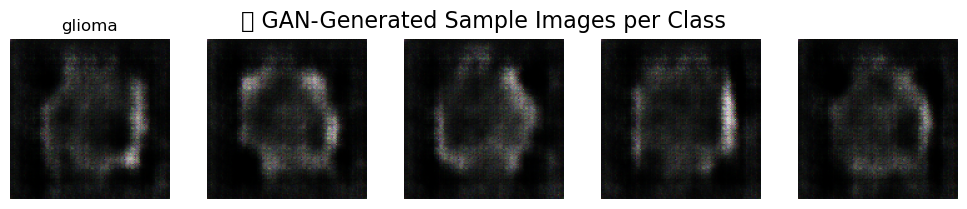

In [ ]:
# === Toggle for Preview Mode ===
ENABLE_PREVIEW = True  # Set to False to skip preview when running full notebook

# === Preview mode parameters ===
PREVIEW_CLASS = class_names[0]        # e.g., 'glioma'
PREVIEW_IMAGES = 5                   # Generate a few images for inspection
PREVIEW_EPOCHS = 1000                 # Light training for fast feedback
PREVIEW_BATCH = 64
PREVIEW_NOISE_DIM = NOISE_DIM
PREVIEW_LABEL_SMOOTH = 0.9
PREVIEW_G_LR = 1e-4
PREVIEW_D_LR = 1e-4

if ENABLE_PREVIEW:
    print(f"\n🔍 Running preview GAN training for class '{PREVIEW_CLASS}'...\n")
    train_gan_for_class(
        class_name=PREVIEW_CLASS,
        num_images=PREVIEW_IMAGES,
        epochs=PREVIEW_EPOCHS,
        batch_size=PREVIEW_BATCH,
        save_interval=200,
        noise_dim=PREVIEW_NOISE_DIM,
        label_smoothing=PREVIEW_LABEL_SMOOTH,
        g_lr=PREVIEW_G_LR,
        d_lr=PREVIEW_D_LR
    )

    # Only preview if folder exists and contains images
    preview_class_path = os.path.join(GAN_ROOT_DIR, PREVIEW_CLASS)
    if os.path.exists(preview_class_path) and len(os.listdir(preview_class_path)) > 0:
        preview_gan_images_per_class(samples_per_class=PREVIEW_IMAGES)
    else:
        print(f"⚠️ No generated images found for '{PREVIEW_CLASS}' to preview.")
else:
    print("🚫 Preview is disabled. Set ENABLE_PREVIEW = True to enable preview training.")


📊 Starting full GAN training across 4 classes...

=== Processing class: glioma ===

🚀 Training GAN for class: glioma


  0%|          | 1/4000 [00:01<1:41:19,  1.52s/it]

[Step 0] D Loss: 0.4137, G Loss: 33.8349


 13%|█▎        | 501/4000 [12:38<1:30:21,  1.55s/it]

[Step 500] D Loss: 0.3956, G Loss: 4.3340


 25%|██▌       | 1001/4000 [25:47<1:21:52,  1.64s/it]

[Step 1000] D Loss: 0.4732, G Loss: 4.9324


 38%|███▊      | 1501/4000 [39:14<1:04:36,  1.55s/it]

[Step 1500] D Loss: 0.5198, G Loss: 4.4655


 50%|█████     | 2001/4000 [53:24<55:08,  1.66s/it]  

[Step 2000] D Loss: 0.5024, G Loss: 4.8500


 63%|██████▎   | 2501/4000 [1:06:26<37:42,  1.51s/it]

[Step 2500] D Loss: 0.8046, G Loss: 3.4093


 75%|███████▌  | 3001/4000 [1:18:34<26:32,  1.59s/it]

[Step 3000] D Loss: 0.5545, G Loss: 3.1780


 88%|████████▊ | 3501/4000 [1:32:17<13:29,  1.62s/it]

[Step 3500] D Loss: 0.6054, G Loss: 4.3217


100%|██████████| 4000/4000 [1:46:03<00:00,  1.59s/it]



💾 Generating 100 synthetic images for class: glioma
✅ Done: 100 GAN images saved to ./gan_augmented\glioma

=== Processing class: meningioma ===

🚀 Training GAN for class: meningioma


  0%|          | 1/4000 [00:01<1:54:17,  1.71s/it]

[Step 0] D Loss: 8.2913, G Loss: 76.2009


 13%|█▎        | 501/4000 [13:29<1:37:33,  1.67s/it]

[Step 500] D Loss: 0.4562, G Loss: 5.8121


 25%|██▌       | 1001/4000 [27:18<1:24:28,  1.69s/it]

[Step 1000] D Loss: 0.5292, G Loss: 6.1123


 38%|███▊      | 1501/4000 [41:11<1:08:20,  1.64s/it]

[Step 1500] D Loss: 0.4781, G Loss: 5.7636


 50%|█████     | 2001/4000 [55:05<55:16,  1.66s/it]  

[Step 2000] D Loss: 0.5425, G Loss: 5.4447


 63%|██████▎   | 2501/4000 [1:08:59<40:26,  1.62s/it]

[Step 2500] D Loss: 0.6250, G Loss: 5.7137


 75%|███████▌  | 3001/4000 [1:22:48<28:30,  1.71s/it]

[Step 3000] D Loss: 0.4851, G Loss: 6.4815


 88%|████████▊ | 3501/4000 [1:36:38<14:07,  1.70s/it]

[Step 3500] D Loss: 0.6006, G Loss: 4.6627


100%|██████████| 4000/4000 [1:50:30<00:00,  1.66s/it]



💾 Generating 100 synthetic images for class: meningioma
✅ Done: 100 GAN images saved to ./gan_augmented\meningioma

=== Processing class: notumor ===

🚀 Training GAN for class: notumor


  0%|          | 1/4000 [00:01<1:56:22,  1.75s/it]

[Step 0] D Loss: 9.1519, G Loss: 93.4012


 13%|█▎        | 501/4000 [13:49<1:35:44,  1.64s/it]

[Step 500] D Loss: 0.4547, G Loss: 5.2300


 25%|██▌       | 1001/4000 [28:35<1:27:50,  1.76s/it]

[Step 1000] D Loss: 0.4613, G Loss: 7.7027


 38%|███▊      | 1501/4000 [43:28<1:13:32,  1.77s/it]

[Step 1500] D Loss: 0.4313, G Loss: 7.4869


 50%|█████     | 2001/4000 [58:20<1:00:04,  1.80s/it]

[Step 2000] D Loss: 0.6309, G Loss: 3.9581


 63%|██████▎   | 2501/4000 [1:13:17<44:45,  1.79s/it]  

[Step 2500] D Loss: 0.5900, G Loss: 5.1302


 75%|███████▌  | 3001/4000 [1:28:10<29:34,  1.78s/it]

[Step 3000] D Loss: 0.4867, G Loss: 5.1428


 88%|████████▊ | 3501/4000 [1:43:05<15:31,  1.87s/it]

[Step 3500] D Loss: 0.5289, G Loss: 5.6402


100%|██████████| 4000/4000 [1:57:58<00:00,  1.77s/it]



💾 Generating 100 synthetic images for class: notumor
✅ Done: 100 GAN images saved to ./gan_augmented\notumor

=== Processing class: pituitary ===

🚀 Training GAN for class: pituitary


  0%|          | 1/4000 [00:01<2:01:37,  1.82s/it]

[Step 0] D Loss: 4.4623, G Loss: 83.7135


 13%|█▎        | 501/4000 [14:57<1:44:28,  1.79s/it]

[Step 500] D Loss: 0.4054, G Loss: 6.6683


 25%|██▌       | 1001/4000 [29:50<1:29:55,  1.80s/it]

[Step 1000] D Loss: 0.3939, G Loss: 8.4739


 38%|███▊      | 1501/4000 [44:47<1:14:53,  1.80s/it]

[Step 1500] D Loss: 0.4204, G Loss: 5.9881


 50%|█████     | 2001/4000 [59:37<1:00:28,  1.81s/it]

[Step 2000] D Loss: 0.4396, G Loss: 7.4661


 63%|██████▎   | 2501/4000 [1:14:30<44:15,  1.77s/it]  

[Step 2500] D Loss: 0.4046, G Loss: 5.8470


 75%|███████▌  | 3001/4000 [1:29:21<29:41,  1.78s/it]

[Step 3000] D Loss: 0.4100, G Loss: 6.7346


 88%|████████▊ | 3501/4000 [1:44:08<14:50,  1.78s/it]

[Step 3500] D Loss: 0.4823, G Loss: 6.1518


100%|██████████| 4000/4000 [1:58:59<00:00,  1.78s/it]



💾 Generating 100 synthetic images for class: pituitary
✅ Done: 100 GAN images saved to ./gan_augmented\pituitary

✅ All GANs trained and/or skipped as appropriate.
🖼️ Previewing GAN-generated images per class...



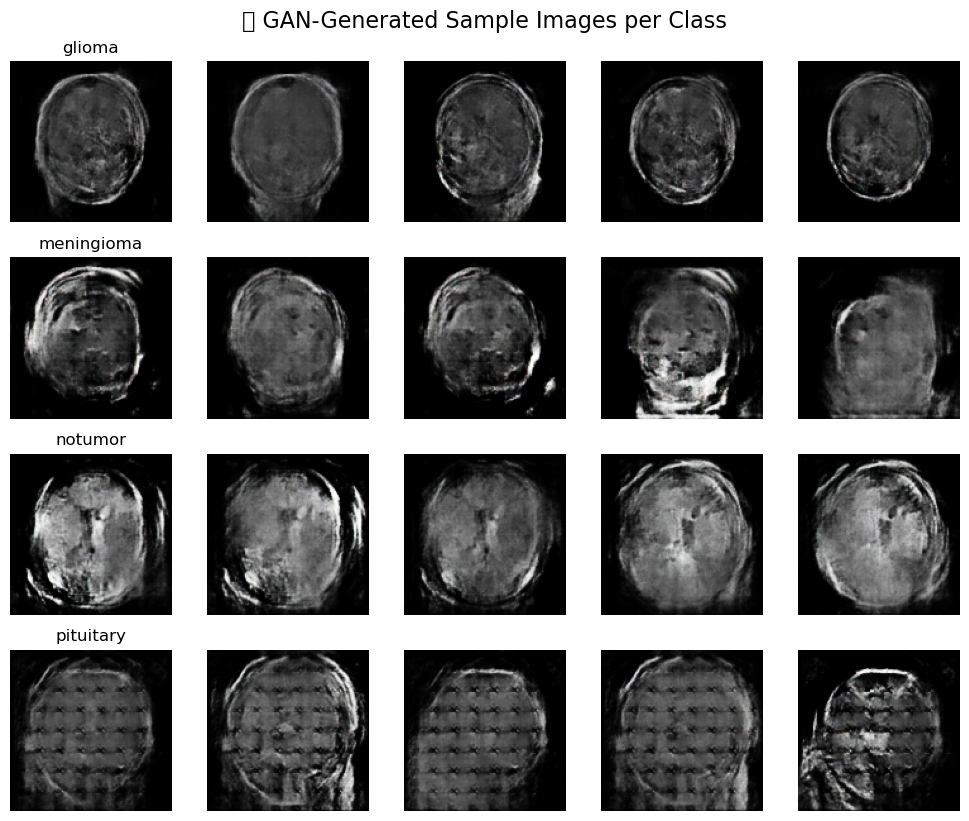

: 

In [ ]:
# === Full GAN training for all classes with longer training ===

FULL_TRAIN_EPOCHS = 4000          # More steps for sharper features
FULL_BATCH_SIZE = 64
GAN_IMAGES_PER_CLASS = 100  # Safe for training sets with 120 real images
FULL_SAVE_INTERVAL = 500
FULL_LABEL_SMOOTHING = 0.9
FULL_G_LR = 1e-4
FULL_D_LR = 1e-4

print(f"📊 Starting full GAN training across {len(class_names)} classes...")

for cls in class_names:
    print(f"\n=== Processing class: {cls} ===")
    train_gan_for_class(
        class_name=cls,
        num_images=GAN_IMAGES_PER_CLASS,
        epochs=FULL_TRAIN_EPOCHS,
        batch_size=FULL_BATCH_SIZE,
        save_interval=FULL_SAVE_INTERVAL,
        noise_dim=NOISE_DIM,
        label_smoothing=FULL_LABEL_SMOOTHING,
        g_lr=FULL_G_LR,
        d_lr=FULL_D_LR
    )

print("\n✅ All GANs trained and/or skipped as appropriate.")
preview_gan_images_per_class(samples_per_class=5)

